Get imports and initialize matplotlib...

In [1]:
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import math
import os
import sys

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Get metadata from csv file...

In [2]:
ps = 16 # num of perspectives
zs = 17 # num of outputs zones

ids = []
targets = OrderedDict()
with open('labels.csv') as f:
    header = f.readline()
    for line in f:
        idzone, label = line.split(',')
        sampleid, zone = idzone.split('_')
        zone_number = int(zone[len('Zone'):]) # string looks like "Zone8" so this chops off "Zone"
        zone_number -= 1
        
        if sampleid not in targets:
            ids.append(sampleid)
            targets[sampleid] = np.zeros(zs)
        targets[sampleid][zone_number] = float(label)
        
test_ids = []
with open('test_labels.csv') as f:
    header = f.readline()
    for line in f:
        idzone, label = line.split(',')
        sampleid, zone = idzone.split('_')
        zone_number = int(zone[len('Zone'):]) # string looks like "Zone8" so this chops off "Zone"
        zone_number -= 1
        
        if sampleid not in test_ids:
            test_ids.append(sampleid)
            

Create our (giant...) matrices for training. Takes up roughly 12 GB of system memory (thankfully mine as 32)

Set n to a value to reduce this size for testing

In [3]:
X_train = [] # training data
y_train = [] # training one hot labels
l_train = [] # training labels
x_test = [] #testing data

w = 512 * ps
h = 660


i = 0
n = 50#len(ids)
nn= len(test_ids)
for sid in ids:
    path = 'data/{}.aps.npz'.format(sid)

    npzfile = np.load(path)
    data = npzfile['arr_0']
    X_train.append(data)
    y_train.append(targets[sid])
    l_train.append(np.argmax(targets[sid]))
    
    i += 1
    print (i, "of", n, end="\r")
    if i >= n:
        break

for sid in test_ids:
    path = 'data/{}.aps.npz'.format(sid)
    npzfile = np.load(path)
    data = npzfile['arr_0']
    x_test.append(data)

X_train = np.moveaxis(X_train, 3, 1)
y_train = np.moveaxis(y_train, 0, 0) # to convert into a matrix (vs a dictionary?)

x_test = np.moveaxis(x_test, 3, 1)

X_train = np.reshape(X_train, [n, w, h])
X_train = X_train.astype(np.float32)

x_test = np.reshape(x_test, [nn, w, h])
x_test = x_test.astype(np.float32)

print (np.shape(X_train))
print (np.shape(y_train))

(50, 8192, 660)
(50, 17)


For some reason the perspective is the last axis in the matrix, move it to be the second matrix so it's more logical (doesn't actually make a difference from a training perspective)

X_train should now be in the form [sampleIndex, perspective, x, y]

Also, moveaxis somehow does this operation while using zero extra memory, no idea how but clearly whoever made it had a better professor for algorithms than Gelfond

Print matrix...

In [6]:
print (X_train[0]) # first sample
print (y_train[0])
print (l_train[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
13


Show Image...

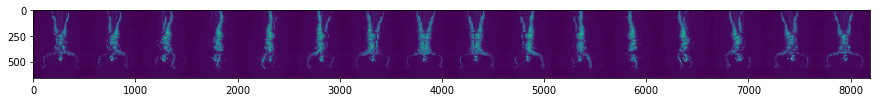

In [11]:
from matplotlib.pyplot import imshow 
figsize(15,4)
im = imshow(np.flipud(x_test[0,:,:]).T, cmap = 'viridis') # 1st sample

make .train() ...

In [6]:


# model hyper parameters
learning_rate = 0.002

def conv_layer(input_data, num_input_channels, num_filters, filter_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias

    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)
    return out_layer
    
def pool(out_layer, pool_shape):
    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 3, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='VALID')
    return out_layer


x = tf.placeholder(tf.float32, [None, w, h], name="inputx")

x_shaped = tf.reshape(x, [-1, w, h, 1])
# x_shaped = tf.cast(x_shaped, tf.float32)

y = tf.placeholder(tf.float16, [None, zs])

l1 = conv_layer(x_shaped, 1, 3, [3, 3], name='l1')
l2 = conv_layer(l1, 3, 16, [3, 3], name='l2')
l3 = pool(l2, [2,2])
l4 = conv_layer(l3, 16, 16, [3, 3], name='l4')
l5 = conv_layer(l4, 16, 16, [3, 3], name='l5')
l6 = pool(l5, [2,2])
l7 = conv_layer(l6, 16, 32, [3, 3], name='l7')
l8 = conv_layer(l7, 32, 32, [3, 3], name='l8')
l9 = conv_layer(l8, 32, 32, [3, 3], name='l9')
l10 = pool(l9, [2,2])
l11 = conv_layer(l10, 32, 32, [3, 3], name='l11')
l12 = conv_layer(l11, 32, 32, [3, 3], name='l12')
l13 = conv_layer(l12, 32, 32, [3, 3], name='l13')
l14 = pool(l13, [2,2])
l15 = conv_layer(l14, 32, 32, [3, 3], name='l15')
l16 = conv_layer(l15, 32, 32, [3, 3], name='l16')
l17 = conv_layer(l16, 32, 32, [3, 3], name='l17')
l18 = pool(l17, [2,2])




#dilation, seperable filter

dumb = 21760 # use shape_check to get this

flattened = tf.reshape(l18, [-1, dumb])

wd1 = tf.Variable(tf.truncated_normal([dumb, 1024], stddev=0.1), name='wd1')
bd1 = tf.Variable(tf.truncated_normal([1024], stddev=0.01), name='bd1')
dense_layer1 = tf.matmul(flattened, wd1) + bd1
dense_layer1 = tf.nn.relu(dense_layer1)

wd2 = tf.Variable(tf.truncated_normal([1024, 1024], stddev=0.1), name='wd2')
bd2 = tf.Variable(tf.truncated_normal([1024], stddev=0.01), name='bd2')
dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
dense_layer2 = tf.nn.relu(dense_layer2)

wd3 = tf.Variable(tf.truncated_normal([1024, zs], stddev=0.1), name='wd3')
bd3 = tf.Variable(tf.truncated_normal([zs], stddev=0.01), name='bd3')
dense_layer3 = tf.matmul(dense_layer2, wd3) + bd3
dense_layer3 = tf.nn.relu(dense_layer3)

y_ = tf.nn.softmax(dense_layer3)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer3, labels=y))


# add an optimiser
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float16))


# with tf.Session() as sess:
#     # initialise the variables
#     sess.run(init_op)
#     total_batch = int(len(y_train) / batch_size)
#     for epoch in range(epochs):
#         avg_cost = 0
#         for i in range(total_batch):
#             batch_x, batch_y = X_train[0][(total_batch*epoch+i):min(len(y_train),(total_batch*(epoch+1)))]
#             _, c = sess.run([optimiser, cross_entropy], 
#                             feed_dict={x: batch_x, y: batch_y})
#             avg_cost += c / total_batch
#         test_acc = sess.run(accuracy, 
#                        feed_dict={x: mnist.test.images, y: mnist.test.labels})
#         print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " 
#                  test accuracy: {:.3f}".format(test_acc))

#     print("\nTraining complete!")
#     print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

shape_check = tf.shape(l18)

In [7]:
# with tf.Session() as sess:
#     # initialise the variables
#     init_op = tf.global_variables_initializer()
#     sess.run(init_op)
    
#     print(sess.run(shape_check, feed_dict={x: X_train[0:1]}))

run .train() ...

In [8]:

batch_size = 1       # num samples to validate per batch (this seems to be the max the card can handle at at time?)


model_name = "VGGbutWRONG_round2"
checkpoint_num = "2" # **** If not valid, will wipe old model!!! ****


saver = tf.train.Saver()
# setup the initialisation operator
init_op = tf.global_variables_initializer()

path = "D:\\ML\\chkpts\\"

with tf.Session() as sess:
    
    if os.path.exists(path+model_name) and os.path.exists(path+model_name+"\\checkpoint_"+checkpoint_num+".ckpt.meta"):
        saver.restore(sess, path+model_name+"\\checkpoint_"+checkpoint_num+".ckpt")
    else:
        print("Invalid model checkpoint to validate")
        sys.exit()
    
    n = len(y_train)
    batches = math.ceil(n / batch_size)
    
    correct_preds = 0
    for i in range(batches):
        s = i * batch_size # start
        e = min((i+1) * batch_size, n)
        x_to_run = X_train[s:e]
        y_to_run = y_train[s:e]
        test_acc = sess.run(accuracy, feed_dict={x: x_to_run, y: y_to_run})
        correct_preds += int(round(test_acc * (e - s)))
        print("Ran Batch ",i," out of ",batches," got ",correct_preds," so far", end="\r")


    print("Correct ",correct_preds," out of ",n)

INFO:tensorflow:Restoring parameters from D:\ML\chkpts\VGGbutWRONG_round2\checkpoint_2.ckpt
Correct  352  out of  1147147  got  352  so far6  so far 521  out of  1147  got  152  so far 537  out of  1147  got  158  so far


In [9]:

# configconfig = tf.ConfigProto()
# configconfig.log_device_placement = True
# configconfig.gpu_options.allow_growth = True

# config = tf.contrib.learn.RunConfig(session_config = configconfig)

